<a href="https://colab.research.google.com/github/Fabkres/ArtificialIntelligence/blob/main/Rede_SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Implementação da rede SOM - Self-Organizing Maps

In [1]:
import matplotlib.pylab as plt
import numpy as np
import gzip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import cv2

%matplotlib inline

In [44]:
class SOM:
    # Inicialização
    def __init__(self, m, n, model=None, net_dim=(30, 30), learning_rate=0.5, iterations=100, n_classes = 10):
        if model is None:
            model = np.random.random((net_dim[0], net_dim[1], m))*0.01
        self.model = model
        self.net_dim = net_dim
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.init_radius = np.average(np.array(net_dim)) / 2
        self.m = m
        self.n = n
        self.n_classes = n_classes
        self.time_constant = iterations / np.log(self.init_radius)
        self.labels = np.zeros((self.model.shape[0], self.model.shape[1], self.n_classes))

    # Processo Competitivo
    def fittest_neuron(self, feature):
        """
        	Encontrar o neurônio mais próximo w.r.t. características de entrada dadas x e modelo

         	:return: o neurônio e seu índice no modelo.
        """
        # calcule a distância entre cada neurônio e a entrada usando operação vetorizada
        distance = np.sqrt(np.sum((self.model - feature) ** 2, axis=2))
        pos = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
        return (self.model[pos], pos)
    
    # Processo Cooperativo
    def decay_radius(self, i):
        return self.init_radius * np.exp(-i / self.time_constant)

    def decay_learning_rate(self, i):
        return self.learning_rate * np.exp(-i / self.iterations)

    # vizinhança gaussiana (dij)=h)
    def h(self, distance, radius):
        return np.exp(-distance / (2* (radius**2)))

    # Processo Adaptativo
    def train(self, x_train):
        zx = np.arange(0, self.net_dim[0], 1)
        zy = np.arange(0, self.net_dim[1], 1)
        zx, zy = np.meshgrid(zx,zy, indexing='ij')
        mesh_init = np.array([zx, zy])

        for i in range(self.iterations):
            # sample = x_train[np.random.randint(0, n, 1)]
            for feature in x_train:

                # encontre o mais apto
                fittest, fittest_idx = self.fittest_neuron(feature)
            
                # decair/reduzir os parâmetros do SOM
                r = self.decay_radius(i)
                l = self.decay_learning_rate(i)
            
                # atualizar o vetor de peso
                mesh_init[0] = mesh_init[0] - fittest_idx[0]
                mesh_init[1] = mesh_init[1] - fittest_idx[1]
                mesh = np.sqrt(np.sum(mesh_init ** 2, axis=0))
                neighbor_mask = mesh < r
                if len(neighbor_mask.flatten()) > 0:
                    mesh[neighbor_mask] = self.h(mesh[neighbor_mask], r)
                    self.model[neighbor_mask] = self.model[neighbor_mask] + l * np.multiply(mesh[neighbor_mask][:, np.newaxis], (feature - self.model)[neighbor_mask])   
    
    def error(self, x):
        distances = np.empty((x.shape[0],))
        for idx, feature in enumerate(x):
            fittest, fittest_idx = self.fittest_neuron(feature)
            distances[idx] = ((fittest - feature) ** 2).sum()
        return distances.mean()

    def label_neurons(self, x_train, y_train):
        # Eliminando os dados de treinamento e selecionando o neurônio vencedor
        for idx, feature in enumerate(x_train):
            distance = np.sqrt(np.sum((self.model - feature) ** 2, axis=2))
            pos = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
            self.labels[pos[0], pos[1], y_train[idx]] += 1
        self.labels = np.argmax(self.labels, axis=2)
        return self.labels

    def accuracy(self, x_test, y_test):
        t = 0
        for idx, feature in enumerate(x_test):
            distance = np.sqrt(np.sum((self.model - feature) ** 2, axis=2))
            pos = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
            if self.labels[pos[0], pos[1]] == y_test[idx]:
                t += 1
        return t / len(y_test)

    def visualize_map(self, x_test, y_test):
        wmap = {}
        im = 0
        for x, t in zip(x_test[:1000], y_test[:1000]):
            distance = np.sqrt(np.sum((self.model - x) ** 2, axis=2))
            pos = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
            wmap[pos] = im
            plt.text(pos[0],  pos[1],  str(t), color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})
            im = im + 1
        plt.axis([0, self.model.shape[0], 0,  self.model.shape[1]])
        plt.show()

    def visualize_u_matrix(self):
        u_matrix = np.zeros((self.model.shape[0], self.model.shape[1]))

        for i in range(self.model.shape[0]):
            for j in range(self.model.shape[1]):
                neighbors = []
                if i > 0:
                    neighbors.append(self.model[i - 1, j])
                if i < self.model.shape[0] - 1:
                    neighbors.append(self.model[i + 1, j])
                if j > 0:
                    neighbors.append(self.model[i, j - 1])
                if j < self.model.shape[1] - 1:
                    neighbors.append(self.model[i, j + 1])

                u_matrix[i, j] = np.mean(np.linalg.norm(neighbors - self.model[i, j], axis=1))

        plt.imshow(u_matrix, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.title('U-Matrix')
        plt.show()



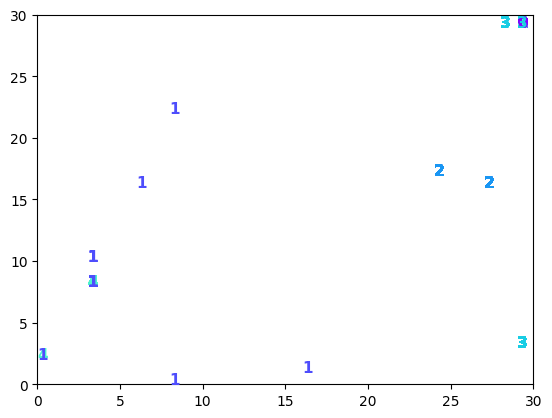

In [45]:
from sklearn.datasets import make_blobs


X, y = make_blobs(n_samples=1000, centers=5, random_state=42)


m = X.shape[1]  # número de característica
n = X.shape[0]  # número de amostras
kohonen = SOM(m=m, n=n, net_dim=(30, 30))

# Treinando a rede SOM
kohonen.train(X)

# Visualizando o mapa treinado
kohonen.visualize_map(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


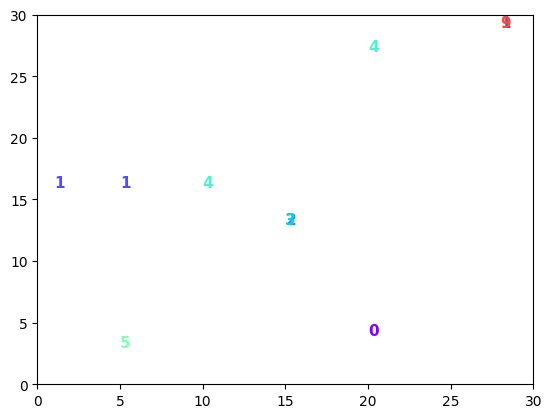

In [48]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler

# Carregar dados MNIST
mnist = fetch_openml('mnist_784')
X = mnist.data.astype(float)
y = mnist.target.astype(int)

# Normalizar os dados
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reduzir o conjunto de dados para poucos dados (opcional)
n_samples = 10
X = X[:n_samples]
y = y[:n_samples]

# Definir as dimensões de entrada e o número de classes
input_dim = X.shape[1]
n_classes = len(np.unique(y))

# Criar uma instância da classe SOM
kohonen = SOM(input_dim, n_classes)

# Treinar a rede
kohonen.train(X)

# Rotular os neurônios vencedores
labels = kohonen.label_neurons(X, y)

# Calcular a precisão da rede
accuracy = kohonen.accuracy(X, y)

# Visualizar o mapa
kohonen.visualize_map(X, y)


In [49]:
accuracy

0.8

###Usando a base de dados wines com a biblioteca MiniSom

In [51]:
!pip install MiniSom
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [52]:
from minisom import MiniSom
import pandas as pd

base = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wines.csv')

X = base.iloc[:,1:14].values
y = base.iloc[:,0].values

from sklearn.preprocessing import MinMaxScaler
normalizador = MinMaxScaler(feature_range = (0,1))
X = normalizador.fit_transform(X)

som = MiniSom(x = 8, y = 8, input_len = 13, sigma = 1.0, learning_rate = 0.5, random_seed = 2)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

som._weights
som._activation_map
q = som.activation_response(X)

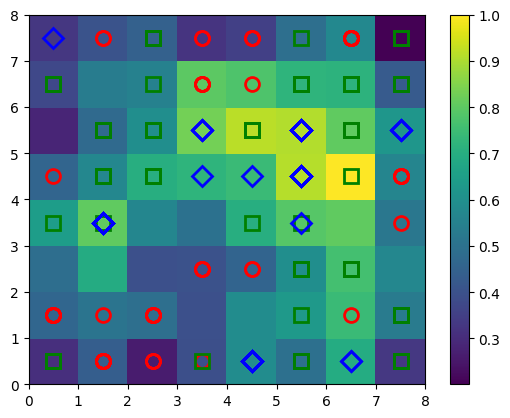

In [53]:

from pylab import pcolor, colorbar, plot
pcolor(som.distance_map().T)
# MID - mean inter neuron distance
colorbar()

w = som.winner(X[2])
markers = ['o', 's', 'D']
color = ['r', 'g', 'b']
y[y == 1] = 0
y[y == 2] = 1
y[y == 3] = 2

for i, x in enumerate(X):
    #print(i)
    #print(x)
    w = som.winner(x)
    #print(w)
    plot(w[0] + 0.5, w[1] + 0.5, markers[y[i]],
         markerfacecolor = 'None', markersize = 10,
         markeredgecolor = color[y[i]], markeredgewidth = 2)